In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

## Data Processing
import os
from tqdm import tqdm
from PIL import Image
import cv2

## Checking out Each Class & Respective Image Size in that Class 
Based off dataset description, most of the images should be (512,512)

In [2]:
train_dir = "/global/scratch/users/kraj21/Training/"
classes = [label for label in os.listdir(train_dir) if label.isalnum()]
classes

['pituitary', 'meningioma', 'glioma', 'notumor']

## Pituitary Image Size class

In [3]:
# Pituitary class has 97% of images are 512 by 512
count = 0
num_images = len(os.listdir(train_dir + classes[0])) # number of files in folder
for img_path in os.listdir(train_dir + classes[0]): # for all image file paths in folder
    image = cv2.imread(train_dir + classes[0] + '/' + img_path, cv2.IMREAD_GRAYSCALE)
    if image.shape == (512,512):
        count += 1
print("Number of images of (512,512):", count / num_images)
print("Number of images:", num_images)

Number of images of (512,512): 0.9732326698695951
Number of images: 1457


## Meningioma Image Class Sizes

In [4]:
count = 0
num_images = len(os.listdir(train_dir + classes[1])) # number of files in folder
for img_path in os.listdir(train_dir + classes[1]): # for all image file paths in folder
    image = cv2.imread(train_dir + classes[1] + '/' + img_path, cv2.IMREAD_GRAYSCALE)
    if image.shape == (512,512):
        count += 1
print("Number of images of (512,512):", count / num_images)
print("Number of images:", num_images)

Number of images of (512,512): 0.8954443614637789
Number of images: 1339


## Glioma Image Sizes Class

In [5]:
count = 0
num_images = len(os.listdir(train_dir + classes[2])) # number of files in folder
for img_path in os.listdir(train_dir + classes[2]): # for all image file paths in folder
    image = cv2.imread(train_dir + classes[2] + '/' + img_path, cv2.IMREAD_GRAYSCALE)
    if image.shape == (512,512):
        count += 1
print("Number of images of (512,512):", count / num_images)
print("Number of images:", num_images)

Number of images of (512,512): 1.0
Number of images: 1321


## No Tumor Image Sizes Class

In [6]:
count = 0
num_images = len(os.listdir(train_dir + classes[3])) # number of files in folder
for img_path in os.listdir(train_dir + classes[3]): # for all image file paths in folder
    image = cv2.imread(train_dir + classes[3] + '/' + img_path, cv2.IMREAD_GRAYSCALE)
    if image.shape == (512,512):
        count += 1
print("Number of images of (512,512):", count / num_images)
print("Number of images:", num_images)

Number of images of (512,512): 0.010658307210031349
Number of images: 1595


#### All tumor affiliated classes are mostly 512 by 512 images, but the no tumor class is randomly sized

## MRI Image Processing:
1. Convert all images to grayscale 
2. Apply a binary mask to identify the largest contour or the brain MRI image from the background
3. Identify MRI ROI and crop to it
4. Resize all MRI ROI to (256, 256) since (512,512) is too much for GPU to handle and does not provide as much value for training the model

**Dataset appears to have MRI scans in different orientations; introducing inherent data variation and hopefully boosting model generalizability**

### Trialing Dataprocessing Process on 1 Image

In [7]:
### Reading in original image
samp_path_img = train_dir + "pituitary/Tr-pi_0044.jpg"
og_image = cv2.imread(samp_path_img, cv2.IMREAD_ANYCOLOR)
print(og_image.shape)

(741, 900, 3)


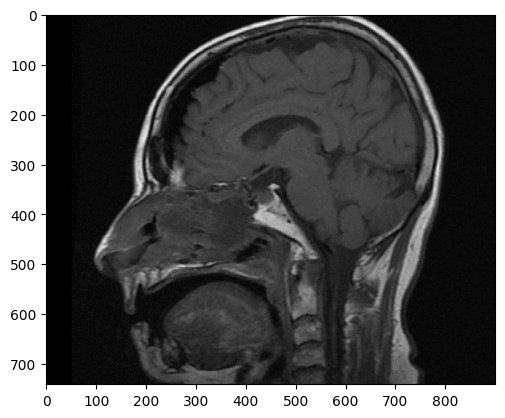

In [8]:
plt.imshow(og_image);

In [9]:
### Reading in grayscale image
samp_path_img = train_dir + "pituitary/Tr-pi_0044.jpg"
gr_image = cv2.imread(samp_path_img, cv2.IMREAD_GRAYSCALE)
print(gr_image.shape)

(741, 900)


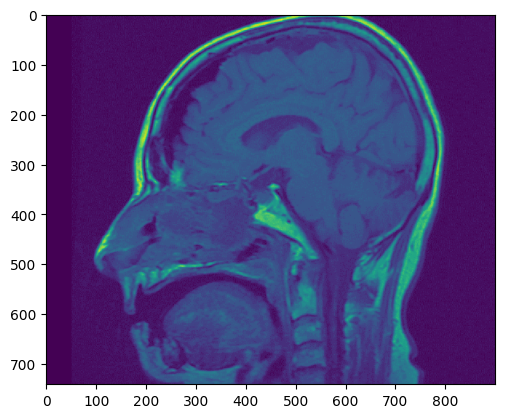

In [10]:
plt.imshow(gr_image);

In [11]:
# Creating binary mask to identify contours or bounded areas in image
ret, thresh = cv2.threshold(gr_image, 30, 255, cv2.THRESH_BINARY)
# Lowering threshold allows more points to go through but makes it easier to fully construct contours by open cv

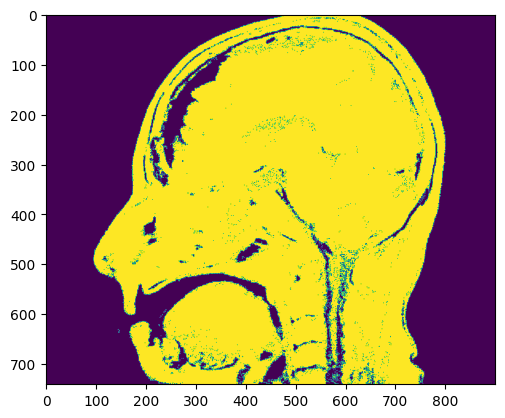

In [12]:
plt.imshow(thresh);

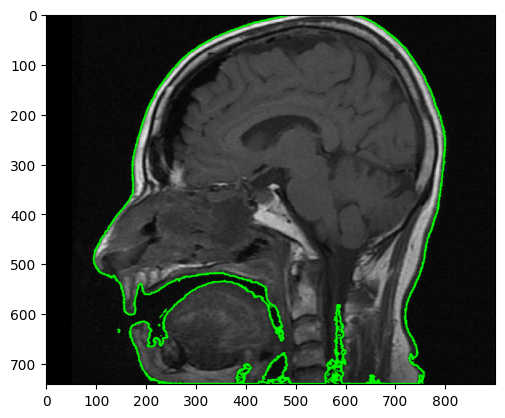

In [13]:
image = cv2.imread(samp_path_img, cv2.IMREAD_ANYCOLOR)
# Storing all contours evident in the mask
contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
                                      
# drawing largest contour on the original image
image_copy = og_image.copy()
cv2.drawContours(image=image, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, 
                 lineType=cv2.LINE_AA)
plt.imshow(image);

In [14]:
c = max(contours, key = cv2.contourArea) # Storing the largest contour or ROI as identified by contour area 
c_2d = np.squeeze(c) # Displays the points defining the contour as x and y coordinate

In [15]:
# Getting extrema points of largest contour
bottom_y = np.max(c_2d[:,1])
top_y = np.min(c_2d[:,1])
left_x = np.min(c_2d[:,0])
right_x = np.max(c_2d[:,0])

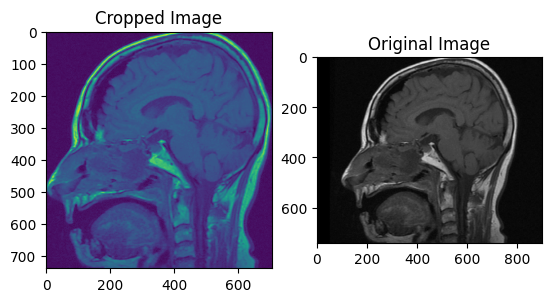

In [16]:
# Showing cropped image
temp = gr_image[top_y :bottom_y, left_x : right_x]
# Showing both images side by side
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(temp)
ax1.set_title("Cropped Image")
ax2.imshow(og_image);
ax2.set_title("Original Image");

### Resizing Both Cropped & Original image

In [17]:
# Resized image after cropping 
resized = cv2.resize(temp, (256,256), interpolation = cv2.INTER_AREA)
# Resized image with no cropping
og_resized = cv2.resize(image, (256,256), interpolation = cv2.INTER_AREA)

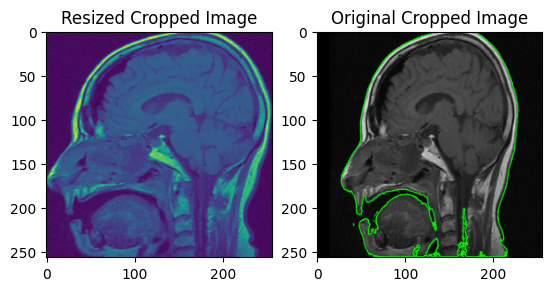

In [18]:
# Showing both images side by side
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(resized)
ax1.set_title("Resized Cropped Image")
ax2.imshow(og_resized);
ax2.set_title("Original Cropped Image");

### Finalized Code for Generating X_train & Y_train datasets via Established Data processing pipeline

In [19]:
def generate_train_test(file_path):
    ind = 0
    # Defining arrays to store labels & images. Dict to note which class corresponds with which value
    y_labels = np.array([])
    num_imgs = sum([len(os.listdir(file_path + cla)) for cla in classes])
    all_imgs = np.ndarray((num_imgs, 256, 256))
    dict_classes = {}
    # Filling the arrays and dict
    # Running process used for prior image for all images now
    for tm_class in range(len(classes)):
        for img_path in os.listdir(file_path + classes[tm_class] + '/'):
            img_arr = cv2.imread(file_path + classes[tm_class] + '/' + img_path, cv2.IMREAD_GRAYSCALE)
            ret, thresh = cv2.threshold(img_arr, 30, 255, cv2.THRESH_BINARY)
            contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_EXTERNAL, 
                                                   method=cv2.CHAIN_APPROX_SIMPLE)
            largest_contour = max(contours, key = cv2.contourArea)
            largest_contour = np.squeeze(largest_contour)
            # Finding points defining largest contour
            bottom_y = np.max(largest_contour[:,1])
            top_y = np.min(largest_contour[:,1])
            left_x = np.min(largest_contour[:,0])
            right_x = np.max(largest_contour[:,0])
            # Cropping image based on these points
            cropped_img = img_arr[top_y :bottom_y, left_x : right_x]
            # Resizing image to smaller size while maintaining aspect ratio
            resized_img = cv2.resize(cropped_img, (256,256), interpolation = cv2.INTER_AREA)
            all_imgs[ind] = resized_img
            y_labels = np.append(y_labels, tm_class)
            ind +=1
        dict_classes[classes[tm_class]] = tm_class
    return all_imgs, y_labels, dict_classes
    

In [20]:
X_train, train_y, dict_train = generate_train_test(train_dir)
print(X_train.shape)
dict_train

(5712, 256, 256)


{'pituitary': 0, 'meningioma': 1, 'glioma': 2, 'notumor': 3}

In [21]:
test_dir = '/global/scratch/users/kraj21/Testing/'
X_test, test_y, dict_test = generate_train_test(test_dir)
print(X_test.shape)
dict_test

(1311, 256, 256)


{'pituitary': 0, 'meningioma': 1, 'glioma': 2, 'notumor': 3}

In [22]:
# Trialing data transform function
fnc_reshape = lambda x: x.reshape(x.shape[0], 1 , x.shape[1], x.shape[2])
reshaped_X_train = fnc_reshape(X_train)
reshaped_X_train.shape

(5712, 1, 256, 256)

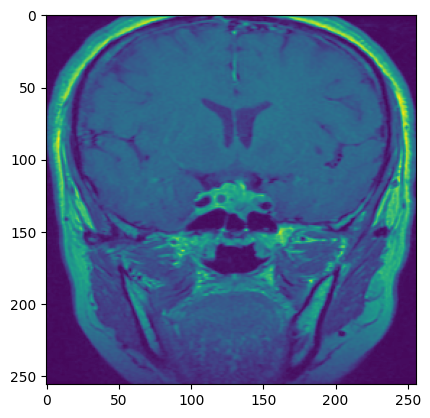

In [23]:
# Seeing how a random cropped image looks like
import random
rand_val = random.randint(0, len(test_y))
plt.imshow(X_test[rand_val]);

## Defining Training and Validation Class

In [24]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [25]:
from torch.optim import SGD, Adam
import torch
from torch import nn
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split

def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size)
    or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, 
                 input_transform=lambda x: x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop=False,l2=False,silent=False, 
              tens_logger = None):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_inputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to tensor of correct shape and type here ###
        # Conversion of input arrays to correct shape
        train_input = self.input_transform(inputs)
        #val_inputs = self.input_transform(val_inputs)
        
        # Conversion of arrays to tensors
        inputs = torch.tensor(train_input, dtype= torch.float).cuda()
        outputs = torch.tensor(outputs, dtype = torch.int64).cuda()
        
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        # Training over self.epoch or the Number of passes over entire dataset
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            # Training over every batch of 16 images
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    # Square and sum each entry in each of the arrays and then sum all outputs from all arrays
                    loss = loss + 1e-5 * sum([(wei ** 2).sum() for wei in self.model.parameters()])
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                ### Compute epoch_loss and epoch_acc
                epoch_loss += loss.detach().item() * batch_importance
                acc = sum(torch.argmax(batch_predictions, dim = 1) == batch_output) / len(batch_output)
                epoch_acc += acc.detach().item() * batch_importance
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            if tens_logger is not None:
                tens_logger.add_scalar("losses", epoch_loss, n_epoch + 1)
                tens_logger.add_scalar("accuracies", epoch_acc, n_epoch + 1)
                tens_logger.add_scalar("val_losses", val_loss, n_epoch + 1)
                tens_logger.add_scalar("val_accuracies", val_acc, n_epoch + 1)
        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies,
               "model": self.model}
        
    def evaluate(self, inputs, outputs, print_acc=True, val = True):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """
        inputs = self.input_transform(inputs)
        tensor_inp = torch.tensor(inputs, dtype = torch.float).cuda()
        tensor_out = torch.tensor(outputs, dtype = torch.int64).cuda()
        with torch.no_grad():
            if val == True:
                preds = self.model(tensor_inp)
                losses = nn.CrossEntropyLoss()(preds, tensor_out)
                losses = losses.item()
                acc = (sum(torch.argmax(preds, axis= 1) == tensor_out) / len(tensor_out)).item()
                if print_acc:
                    print("Accuracy: %.3f" % acc)
                return losses, acc
            else:
                pred_probs = self.model(tensor_inp)
                pred_labels = torch.argmax(pred_probs, axis= 1)
                acc = (sum(torch.argmax(pred_probs, axis= 1) == tensor_out) / len(tensor_out)).item()
                print("Test Accuracy: %.3f" % acc)
                return pred_labels,pred_probs
        
        

/global/home/users/kraj21/.conda/envs/ml_life/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Definition

In [26]:
import torch
from torch import nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(in_channels= 1, out_channels= 7,kernel_size = 5, stride = 1, padding= 2),
                                   nn.Conv2d(in_channels= 7, out_channels= 12,kernel_size = 3, stride = 1, padding= 1)])
        self.bn = nn.ModuleList([nn.BatchNorm2d(7), nn.BatchNorm2d(12)])
        self.fc = nn.ModuleList([nn.Linear(3072, 4)])
        self.pooling = nn.AvgPool2d(kernel_size = 4)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        for i in range(2):
            x = self.pooling(self.activation(self.bn[i](self.conv[i](x))))
        x = nn.Flatten() (x)
        x = self.fc[0](x)
        return x

In [27]:
from torchsummary import summary
model = CNN()
# Input is the (number of channels, image height, image width) if input is 2d, essentially the 2 dimensions of it
s = summary(model, (1,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 7, 256, 256]         182
├─ModuleList: 1                          []                        --
|    └─BatchNorm2d: 2-2                  [-1, 7, 256, 256]         14
├─ReLU: 1-1                              [-1, 7, 256, 256]         --
├─AvgPool2d: 1-2                         [-1, 7, 64, 64]           --
├─ModuleList: 1                          []                        --
|    └─Conv2d: 2-3                       [-1, 12, 64, 64]          768
├─ModuleList: 1                          []                        --
|    └─BatchNorm2d: 2-4                  [-1, 12, 64, 64]          24
├─ReLU: 1-3                              [-1, 12, 64, 64]          --
├─AvgPool2d: 1-4                         [-1, 12, 16, 16]          --
├─ModuleList: 1                          []                        --
|    └─Linear

In [28]:
from torch.utils.tensorboard import SummaryWriter
cnn_logger = SummaryWriter(log_dir = 'CNN_MRI_256_5712')
cnn_logger.flush()

## Model Training via Cross Validation:

In [29]:
# Defining dataframe to store results from 3 fold testing on various versions of model 
train_res = pd.read_csv('4_29_230PM', index_col = 0)
train_res

,epochs,batch_size,LR,avg_train_acc,avg_val_acc,L2,num_layers,num_filters,kernel_sizes
0,28,16,0.001,0.983894,0.911590,True,2,7 & 12,5 & 3
1,28,16,0.001,0.981968,0.902836,True,2,5 & 10,5 & 3
2,28,16,0.001,0.979779,0.906688,True,2,5 & 10,7 & 3
3,28,16,0.001,0.985732,0.908438,True,2,5 & 10,7 & 5
4,28,16,0.001,0.983456,0.907038,True,2,5 & 10,5 & 5
5,28,16,0.001,0.982230,0.911415,True,2,5 & 10,9 & 5
6,24,16,0.001,0.981968,0.909139,True,2,5 & 10,11 & 5
7,24,16,0.001,0.984681,0.909839,True,2,7 & 12,9 & 5
8,24,16,0.001,0.991246,0.910889,True,2,10 & 15,9 & 5
9,24,16,0.001,0.976891,0.904762,True,3,5 & 8 & 12,9 & 7 & 5


  4%|▎         | 1/27 [00:09<04:17,  9.91s/it]

Epoch 1/27 - Loss: 0.748 - Acc: 0.700
              Val_loss: 0.563 - Val_acc: 0.788


 41%|████      | 11/27 [01:45<02:32,  9.55s/it]

Epoch 11/27 - Loss: 0.174 - Acc: 0.941
              Val_loss: 0.333 - Val_acc: 0.887


 78%|███████▊  | 21/27 [03:20<00:57,  9.54s/it]

Epoch 21/27 - Loss: 0.088 - Acc: 0.975
              Val_loss: 0.394 - Val_acc: 0.882


func:'train'  took: 259.0629 sec


  4%|▎         | 1/27 [00:09<04:11,  9.68s/it]

Epoch 1/27 - Loss: 0.728 - Acc: 0.722
              Val_loss: 0.537 - Val_acc: 0.805


 41%|████      | 11/27 [01:45<02:33,  9.57s/it]

Epoch 11/27 - Loss: 0.179 - Acc: 0.938
              Val_loss: 0.315 - Val_acc: 0.893


 78%|███████▊  | 21/27 [03:20<00:57,  9.54s/it]

Epoch 21/27 - Loss: 0.085 - Acc: 0.973
              Val_loss: 0.396 - Val_acc: 0.889


func:'train'  took: 258.5381 sec


  4%|▎         | 1/27 [00:09<04:09,  9.58s/it]

Epoch 1/27 - Loss: 0.684 - Acc: 0.742
              Val_loss: 0.548 - Val_acc: 0.798


 41%|████      | 11/27 [01:45<02:32,  9.55s/it]

Epoch 11/27 - Loss: 0.139 - Acc: 0.955
              Val_loss: 0.341 - Val_acc: 0.899


 78%|███████▊  | 21/27 [03:20<00:57,  9.52s/it]

Epoch 21/27 - Loss: 0.085 - Acc: 0.969
              Val_loss: 0.388 - Val_acc: 0.897


func:'train'  took: 258.1752 sec
Average train accuracy: 0.985381652661062
Average validation accuracy: 0.9087885618209839


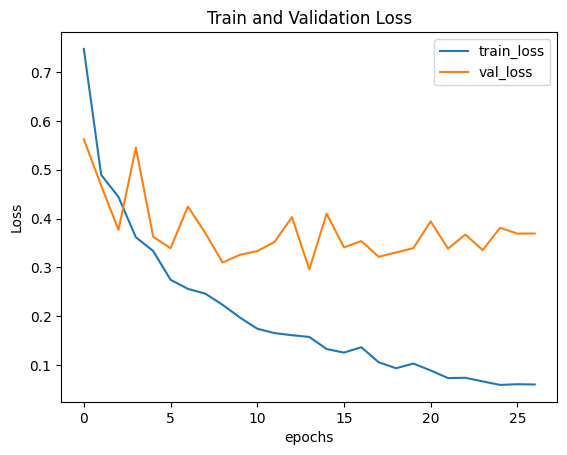

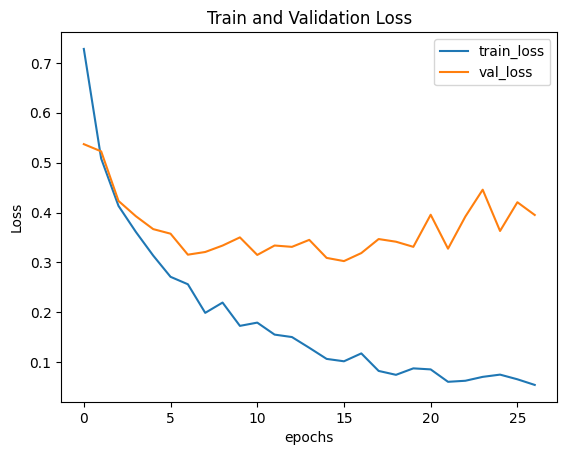

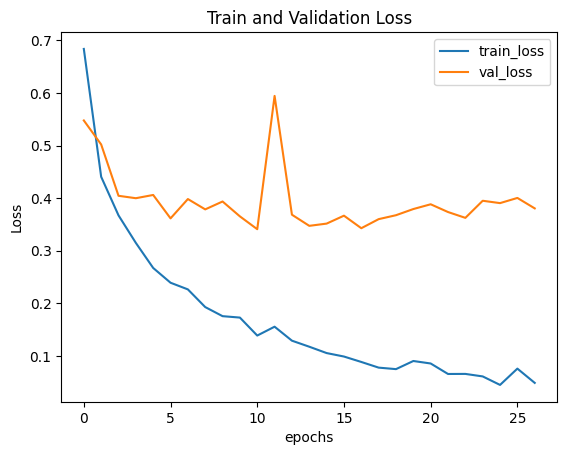

In [39]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits= 3, shuffle = True)
# Initializing lists to store values for reporting mean acc and for confusion matrix
train_acc = []
all_test_pred_labels = []
val_acc = []
# Defining parameters tested in this iteration 
epochs = 27
batchsize = 16
lr = 1e-3
l2 = True
num_layers = 2
num_filters =  "7 & 12"
kernel_sizes = "5 & 3"
for train_ind, test_ind in kfold.split(X_train, train_y):
        trainfold_X = X_train[train_ind]
        trainfold_y = train_y[train_ind]
        valfold_x = X_train[test_ind]
        valfold_y = train_y[test_ind]
        cnn = CNN().cuda()
        mlp_trainer = Trainer(cnn, 'adam', 1e-3, epoch= epochs, batch_size= batchsize)
        train_val_dict = mlp_trainer.train(trainfold_X, trainfold_y, valfold_x, valfold_y, early_stop= True, l2= l2,
                                           tens_logger= cnn_logger)
        # Filling train and validation accuracies
        train_acc.append(train_val_dict['accuracies'][-1])
        val_acc.append(max(train_val_dict['val_accuracies']))
        # Plotting Training & Validation Loss
        plt.figure()
        plt.plot(train_val_dict['losses'])
        plt.plot(train_val_dict['val_losses'])
        plt.legend(['train_loss', 'val_loss'])
        plt.title("Train and Validation Loss")
        plt.ylabel('Loss')
        plt.xlabel('epochs');
print('Average train accuracy:', np.mean(train_acc))
print('Average validation accuracy:', np.mean(val_acc))
train_res.loc[len(train_res.index)] = [epochs, batchsize, lr, np.mean(train_acc), np.mean(val_acc), l2,
                                       num_layers, num_filters, kernel_sizes]

In [40]:
train_res

,epochs,batch_size,LR,avg_train_acc,avg_val_acc,L2,num_layers,num_filters,kernel_sizes
0,28,16,0.001,0.983894,0.911590,True,2,7 & 12,5 & 3
1,28,16,0.001,0.981968,0.902836,True,2,5 & 10,5 & 3
2,28,16,0.001,0.979779,0.906688,True,2,5 & 10,7 & 3
3,28,16,0.001,0.985732,0.908438,True,2,5 & 10,7 & 5
4,28,16,0.001,0.983456,0.907038,True,2,5 & 10,5 & 5
5,28,16,0.001,0.982230,0.911415,True,2,5 & 10,9 & 5
6,24,16,0.001,0.981968,0.909139,True,2,5 & 10,11 & 5
7,24,16,0.001,0.984681,0.909839,True,2,7 & 12,9 & 5
8,24,16,0.001,0.991246,0.910889,True,2,10 & 15,9 & 5
9,24,16,0.001,0.976891,0.904762,True,3,5 & 8 & 12,9 & 7 & 5


In [89]:
train_res.sort_values(by = 'avg_val_acc', ascending= False).head(10)

,epochs,batch_size,LR,avg_train_acc,avg_val_acc,L2,num_layers,num_filters,kernel_sizes
19,27,16,0.001,0.984156,0.918943,True,2,7 & 12,5 & 3
21,27,16,0.001,0.981618,0.915616,True,2,7 & 12,5 & 3
17,27,16,0.001,0.984769,0.914741,True,2,7 & 12,5 & 3
20,27,16,0.001,0.984331,0.914566,True,2,7 & 12,5 & 3
18,27,16,0.001,0.985294,0.913691,True,2,7 & 12,5 & 3
0,28,16,0.001,0.983894,0.911590,True,2,7 & 12,5 & 3
5,28,16,0.001,0.982230,0.911415,True,2,5 & 10,9 & 5
16,27,16,0.001,0.982668,0.910889,True,2,7 & 12,5 & 3
8,24,16,0.001,0.991246,0.910889,True,2,10 & 15,9 & 5
7,24,16,0.001,0.984681,0.909839,True,2,7 & 12,9 & 5


## Final Model Accuracy

In [42]:
test_pred_labels, model_outputs = mlp_trainer.evaluate(X_test, test_y, print_acc= True, val= False)

Test Accuracy: 0.905


## Classification Metrics for Final Model

In [43]:
from sklearn.metrics import confusion_matrix
model_conf = confusion_matrix(y_pred= test_pred_labels.cpu().numpy(), y_true= test_y, labels= [0,1,2,3])
model_conf

array([[283,   6,  11,   0],
       [ 13, 246,  32,  15],
       [  4,  31, 263,   2],
       [  0,   9,   2, 394]])

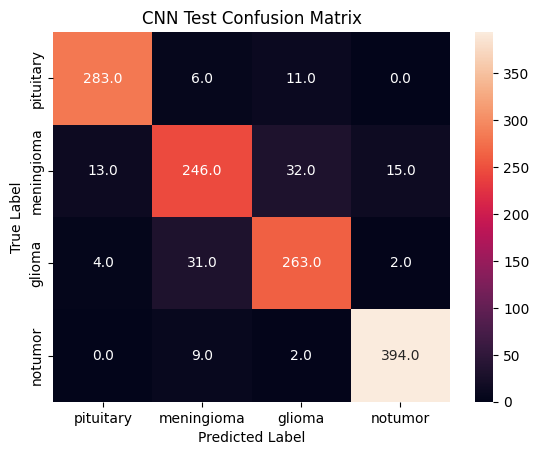

In [44]:
fig, ax = sns.heatmap(model_conf,annot = True, fmt=".1f", xticklabels= dict_test.keys(), yticklabels= dict_test.keys())
ax.set_title("CNN Test Confusion Matrix");
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label");
fig.savefig("Conv")

In [45]:
from sklearn.metrics import classification_report
print(classification_report(test_y, test_pred_labels.cpu().numpy(), target_names=dict_test.keys()))

              precision    recall  f1-score   support

   pituitary       0.94      0.94      0.94       300
  meningioma       0.84      0.80      0.82       306
      glioma       0.85      0.88      0.87       300
     notumor       0.96      0.97      0.97       405

    accuracy                           0.90      1311
   macro avg       0.90      0.90      0.90      1311
weighted avg       0.90      0.90      0.90      1311



### Aside: Potential Extension -> Highlighting Images that are Potentially Misclassified
The core idea is that the model is never going to be a hundred percent accurate and may sometimes predict 2 classes with slight differences in the respective probabilities for the tumor type of an image. In this scenario, the slight difference is the 2 highest probabilities that the model has predicted the tumor type to be are within 10% of each other. This state will be defined as the model is unsure of the true class of the tumor type of the MRI image. If this occurs, the model will store the indicies of the images it is unsure that it correctly classified for the radiologist to verify in a further analysis. 
    
**Steps:**
1. Storing the probabilities used to generate the predicted labels
2. Determine the 2 highest probabilities for each image 
3. If difference between the 2 images is less than 0.1, store the indices
4. Return indices of images that the model is unsure of 

In [107]:
def unsure_image(model_output):
    probs = nn.Softmax(dim = 1)(model_output).cpu().numpy()
    largest_2_probs = np.sort(probs)[:, -2:] 
    unsure_ind = np.squeeze(np.diff(largest_2_probs) < 0.10).nonzero()[0]
    return unsure_ind

In [108]:
uns_inds = unsure_image(model_output= model_outputs)
uns_inds

array([ 89, 159, 316, 347, 373, 461, 541, 567, 578, 588, 647, 674, 692,
       715, 838])

In [109]:
pred_mod_uns = torch.argmax(nn.Softmax(dim = 1)(model_outputs), dim = -1).cpu().numpy()[uns_inds]
pred_mod_uns

array([1, 2, 1, 1, 1, 2, 3, 2, 2, 2, 1, 2, 1, 2, 1])

In [110]:
ans_mod_uns = (test_y[uns_inds]).astype(int)
ans_mod_uns

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

In [111]:
decimal_mod_uns_correct = np.sum(pred_mod_uns == ans_mod_uns) / len(ans_mod_uns)
decimal_mod_uns_correct

0.3333333333333333